<a href="https://colab.research.google.com/github/jaegon-kim/python_study/blob/main/src/ai_essential_250317/house_price_prediction/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction
- **목표**
  - 이 워크샵은 주어진 데이터셋을 이용해 심층신경망 모델을 학습시켜 주택의 최종 판매 가격(SalePrice)을 예측하는 것이 최종 목표입니다.

- **데이터셋 정보**
  - 데이터셋은 총 79개의 설명 변수와 타겟 변수인 주택 가격(SalePrice)로 구성됩니다.
  - 설명 변수는 주택의 다양한 특성(예: 건축 연도, 면적, 위치, 방 개수 등)을 포함합니다.
  - 데이터는 판매 가격이 포함된 학습용 데이터인 `X`, `y` 와 판매 가격이 포함되지 않은 평가용 데이터인 `TEST`파일로 나뉘며, 각각 모델 학습 및 평가에 사용됩니다.
    - 평가용 데이터 `TEST`의 판매 가격(SalePrice)를 예측 후 리더보드로 제출하여 평가합니다.

- **문제 유형**
  - 이 워크샵은 회귀 문제로 연속형 변수를 예측하는 것이 목표입니다. 모델의 성능은 `Mean Absolute Error`로 측정됩니다.

## 1. 환경 설정

In [1]:
%%capture
!pip install JAEN -U

In [2]:
# 그대로 실행하세요.
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from JAEN.utils import plot_training_results


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/sdn/anaconda3/envs/python311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

## 2. 데이터 로드

In [3]:
from JAEN.datasets import load_house_price
X, y, TEST = load_house_price()
X.shape, y.shape, TEST.shape

(torch.Size([1460, 79]), torch.Size([1460, 1]), torch.Size([1459, 79]))

In [4]:
train_X, train_y = X[:1000, :], y[:1000, :]
test_X, test_y = X[1000:, :], y[1000:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([1000, 79]),
 torch.Size([1000, 1]),
 torch.Size([460, 79]),
 torch.Size([460, 1]))

## 3. 제출 예시 코드

## 4. 심층신경망 모델을 구성하고 학습하여 TEST를 예측해보세요.
- TEST의 예측 결과는 `comp.prediction`에 대입해주세요. **torch.tensor** 형태여야합니다.

In [5]:
# DataLoader 생성
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=32, shuffle=True)


In [42]:
# DNN 모델 구성
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용

    def forward(self, x):
        #x = self.relu(self.fc1(x))
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN().to(device)
summary(model)


Layer (type:depth-idx)                   Param #
DNN                                      --
├─Linear: 1-1                            10,240
├─Linear: 1-2                            8,256
├─Linear: 1-3                            65
├─ReLU: 1-4                              --
├─Dropout: 1-5                           --
Total params: 18,561
Trainable params: 18,561
Non-trainable params: 0

In [7]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    # - len(train_loader): 평균 Loss
    return running_loss / len(train_loader)

In [8]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

In [43]:
# 손실함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [44]:
train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(100):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 39983897856.0 Test Loss : 37444675037.86667
Epoch 2 Train Loss : 39294186240.0 Test Loss : 37446305518.933334
Epoch 3 Train Loss : 39714557184.0 Test Loss : 38430993749.333336
Epoch 4 Train Loss : 39663010048.0 Test Loss : 37612655957.333336
Epoch 5 Train Loss : 39190224640.0 Test Loss : 37189237009.066666
Epoch 6 Train Loss : 39196790464.0 Test Loss : 38950830216.53333
Epoch 7 Train Loss : 38895205568.0 Test Loss : 36307022097.066666
Epoch 8 Train Loss : 38303114688.0 Test Loss : 35885159901.86667
Epoch 9 Train Loss : 37497265472.0 Test Loss : 35605225335.46667
Epoch 10 Train Loss : 36846013888.0 Test Loss : 34363927756.8
Epoch 11 Train Loss : 35688188544.0 Test Loss : 33201060659.2
Epoch 12 Train Loss : 34012652032.0 Test Loss : 31920272179.2
Epoch 13 Train Loss : 32326561472.0 Test Loss : 30430242406.4
Epoch 14 Train Loss : 30269445248.0 Test Loss : 28704268697.6
Epoch 15 Train Loss : 28713290432.0 Test Loss : 26956431086.933334
Epoch 16 Train Loss : 26422974656

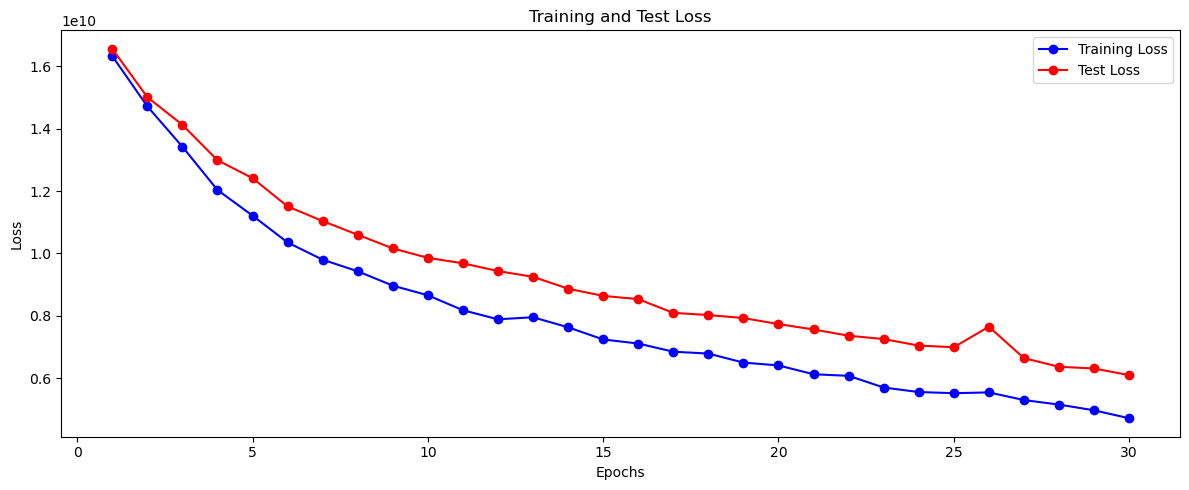

In [45]:
plot_training_results(train_losses[20:50], test_losses[20:50])

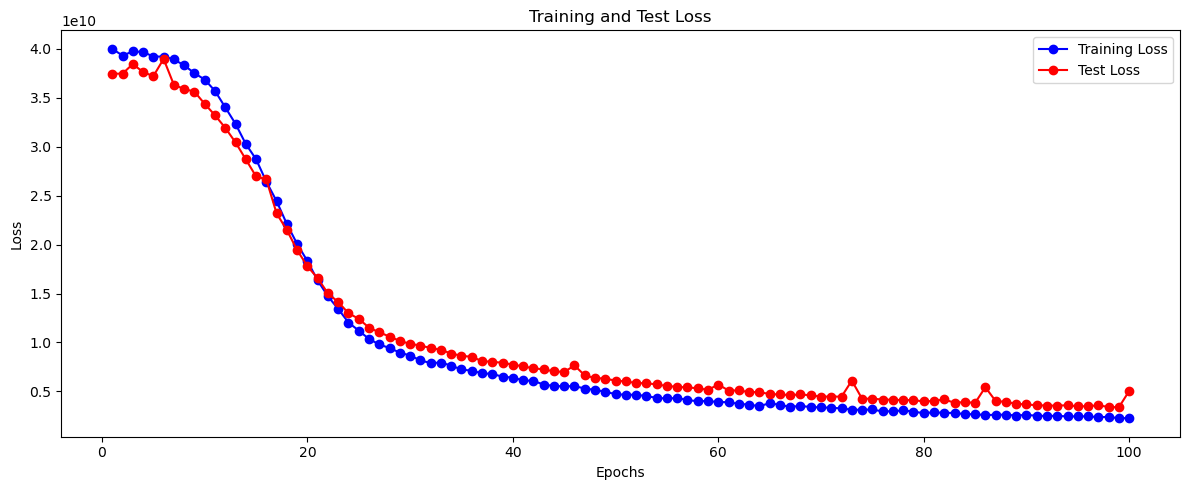

In [46]:
plot_training_results(train_losses, test_losses)

In [13]:
# 사용자명을 입력하세요. (이름이 아니여도 괜찮습니다.)
username = "김재곤"
assert username, "username 변수에 값이 설정되지 않았습니다."

# 그대로 실행하세요.
from JAEN.competition import Competition
comp = Competition(
    username=username,
    course_name='AI Essential',
    course_round='0317(1)',
    competition_name='House Price Prediction'
)

# 학습된 모델의 TEST 예측
model.eval()
TEST2 = TEST.to(device)
with torch.no_grad():
    outputs = model(TEST2)
outputs

# comp.prediction에 TEST 예측 결과 대입
comp.prediction = outputs
comp.prediction

# 제출
#comp.submit()

tensor([[110737.5078],
        [146409.1406],
        [186595.2969],
        ...,
        [168939.0781],
        [ 99360.1719],
        [247547.5938]], device='cuda:0')